### Analysing inside higher education Capital Campaign Data

**NoteBook Objective: Objective of this notebook is to analyse insights from the data available on the inside higher ed website: http://www.insidehighered.com/capital_campaigns# to perform descriptive analysis on what has happened?**

**NOTE:** 
- **There is not enough data to perform predictive or prescriptive analysis**
- **Refresh web page if nbviewer page do not show CONCLUSION at the end of this notebook.**

The provided dataset shows the status of fund-raising campaigns by colleges and universities:
    - includes campaigns start and end dates,
    - Universities campaign priorities vs Donors Donation reasons
    - all gifts to higher education of at least USD 50 million to maximum, and 
    - the largest gift reported by each college and university.

#### Questions: We have two sets of data to be exploited to form valuable insights:
1. Data 1: University campaign, goal, raised to date, duration and their priorities
    - KMeans Clusterin labelling Goal vs Raised for an association
    - University priorities to accumulate a fund
    - Top and bottom Fundraising Universities and The Capital raised
    - Distribution of a number of campaign years, Would long campaign raise more money?
    

2. Data 2: Donors giving more than USD 50 million and their purpose
    - Amount of donation over the years?
    - Number of donors over the years?
    
    
3. Basic Natural Language Processing to identify hidden knowledge contrasting what universities need and donors expectations.
     - Bag of words model for the universities vs donors
     - word cloud contrasting university needs vs donors expectations.

#### Step 1: Load Required Data and Analytical and Visual Python Packages
Following data files: higherEd.xlsx with three sheets - 'Capital Campaign', 'Gifts over 50M USD', 'Largest gift by college'

In [1]:
# Load data

%matplotlib inline
import nltk
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from pandas import ExcelWriter
from pandas import ExcelFile

#### Step 2: Let us create additional useful columns and fix missing values for dataset 1

- There are 82 rows and 9 columns
  - RangeIndex: 82 entries, 0 to 81
  - Data columns (total 9 columns):
      - College 82 non-null object - University or college name
      - Year Started 82 non-null int64 - Campaign start year
      - End Date 82 non-null int64 - Campaign End Year
      - Top priorities 82 non-null object - University fundraising priorities, text column
      - Ended 82 non-null bool - campaign ended or not, bool
      - Goal (USD millions) 82 non-null float64 - Goal in USD millions
      - Raised (USD millions) 82 non-null float64 - Raised to date in USD Millions
      - Years 82 non-null int64 - Number of campaign years
      - Raised Against Goal 82 non-null float64 - Substracting goal from raised

In [2]:
#Universities Data
uni = pd.read_excel('./input/higherEd.xlsx', sheetname='Capital Campaign')

# Create features, remove duplicates, adjust Nan values, define column datatypes

def replace(s, r1, r2):
    s = str(s).replace(r1,r2)
    return s

def fixdata(df):
    df['End Date'] = df.apply(lambda r: replace(r['End Date'], "No end date", '2020'), axis=1)
    df['Ended'] = df['End Date'].str.contains('Ended', regex=False)
    df['End Date'] = df.apply(lambda r: replace(r['End Date'], "Ended", ''), axis=1)
    df['Goal (USD millions)'] = (df['Goal'].astype(float)/1000000).astype(str)
    df['Raised (USD millions)'] = (df['Raised to Date'].astype(float)/1000000).astype(str)
    df = df.drop(['Goal', 'Raised to Date'], axis=1)
    df = df.astype({"College": str, "End Date": int,"Top priorities": str, "Goal (USD millions)": float, "Raised (USD millions)": float, "Ended": bool})
    df['No of Years'] = df['End Date'].sub(df['Year Started'], axis = 0)
    df['Raised Against Goal'] = df['Raised (USD millions)'].sub(df['Goal (USD millions)'], axis = 0)
    df['Raised (USD millions)'] = df['Raised (USD millions)'].fillna(17.0)
    df['Raised Against Goal'] = df['Raised Against Goal'].fillna(0)
    return df

uni = fixdata(uni)
uni.info()
uni.head(n=15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
College                  82 non-null object
Year Started             82 non-null int64
End Date                 82 non-null int32
Top priorities           82 non-null object
Ended                    82 non-null bool
Goal (USD millions)      82 non-null float64
Raised (USD millions)    82 non-null float64
No of Years              82 non-null int64
Raised Against Goal      82 non-null float64
dtypes: bool(1), float64(3), int32(1), int64(2), object(2)
memory usage: 5.0+ KB


,College,Year Started,End Date,Top priorities,Ended,Goal (USD millions),Raised (USD millions),No of Years,Raised Against Goal
0,Amherst College,2018,2023,"Student aid, a new science center, growth of t...",False,625.0,333.0,5,-292.0
1,ArtCenter College of Design,2018,2020,"Scholarships, learning spaces",False,100.0,84.0,2,-16.0
2,Auburn University,2008,2018,Scholarships and endowed chairs,True,1000.0,1200.0,10,200.0
3,Baylor University,2018,2023,Endowments for student aid and faculty positions,False,1100.0,542.0,5,-558.0
4,Bucknell University,2012,2017,Student aid and academic endowments,True,500.0,513.0,5,13.0
5,California State University at Los Angeles,2018,2022,"Academic programs, student success programs",False,75.0,45.0,4,-30.0
6,Carleton College,2018,2021,"Financial aid, new learning facilities, experi...",False,400.0,315.7,3,-84.3
7,Central Michigan University,2019,2022,Programs related to student success,False,100.0,101.0,3,1.0
8,Centre College,2015,2019,Scholarship programs,True,200.0,210.0,4,10.0
9,Christendom College,2016,2018,"Chapel, endowment",False,40.0,45.0,2,5.0


#### Step 3: Let us create additional useful columns and fix missing values for dataset 2 - Donors Data

There are 120 rows and 4 columns, moved text data about primary purpose to donor text dataframe.

    Int64Index: 120 entries, 0 to 77
    Data columns (total 4 columns):
    Amount Given (USD millions)    120 non-null float64
    College                        120 non-null object
    Primary Purpose                120 non-null object
    Year                           120 non-null int64


In [3]:
#Donors Data (Donations over USD 50 millions)
don1 = pd.read_excel('./input/higherEd.xlsx', sheetname='Largest gift by college')
don2 = pd.read_excel('./input/higherEd.xlsx', sheetname='Gifts over 50M USD')

don1['Amount Given (USD millions)'] = (don1['Amount Given'].astype(float)/1000000).astype(float)
don1['Year'] = (don1['Year Given'].astype(int))
don1 = don1.drop(['Year Given', 'Amount Given'], axis=1)

don2['Amount Given (USD millions)'] = (don2['Amount Given'].astype(float)/1000000).astype(float)
don2 = don2.drop(['Amount Given'], axis=1)

donor = don1.append([don2])
donor = donor.drop_duplicates()
donortext = donor.filter(['Primary Purpose'], axis=1)
donortext = donortext.drop_duplicates()
donor.info()
donor.head(n=15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 77
Data columns (total 4 columns):
Amount Given (USD millions)    120 non-null float64
College                        120 non-null object
Primary Purpose                120 non-null object
Year                           120 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ KB


,Amount Given (USD millions),College,Primary Purpose,Year
0,650.0,Broad Institute of Harvard University and Mass...,Psychiatric research,2014
1,600.0,California Institute of Technology,"To promote collaborative, interdisciplinary re...",2001
2,600.0,Columbia University,Medical school and New York-Presbyterian Hospital,2017
3,500.0,Oregon Health & Science University,Challenge/matching grant,2013
4,500.0,University of Oregon,New campus focused on acceleration of science,2016
5,500.0,"University of California, San Francisco",Planning a new hospital,2018
6,460.0,Olin College of Engineering,Creating the college,1997
7,400.0,Stanford UniversityTied,School for Humanities and Sciences,2001
8,400.0,Harvard University,Endowment for engineering program,2015
9,400.0,Stanford UniversityTied,Scholarships for graduate students,2016


In [4]:
donor = donor.drop(['Primary Purpose'], axis=1)
donor = donor.drop_duplicates()
donor = donor.drop([31, 67])

#### Step 4: Identifying and Labelling hidden cluster using Kmeans on University Data

Basically KMeans clustering is cluster with a nearest mean.

-  Unsupervised Learning to verify lables or association between Goal against raised to date.
-  plot kmeans labels against goal, raised and see if it shows cluster.

Note: excluding irrelevant columns such as 'College', 'Year Started', 'End Date', 'Top priorities', 'Raised Against Goal', 'Years'
Make sure it does not have Nan Values before applying K means

In [5]:
data = uni.drop(['College', 'Year Started', 'End Date', 'Top priorities', 'Raised Against Goal', 'No of Years'], axis=1)

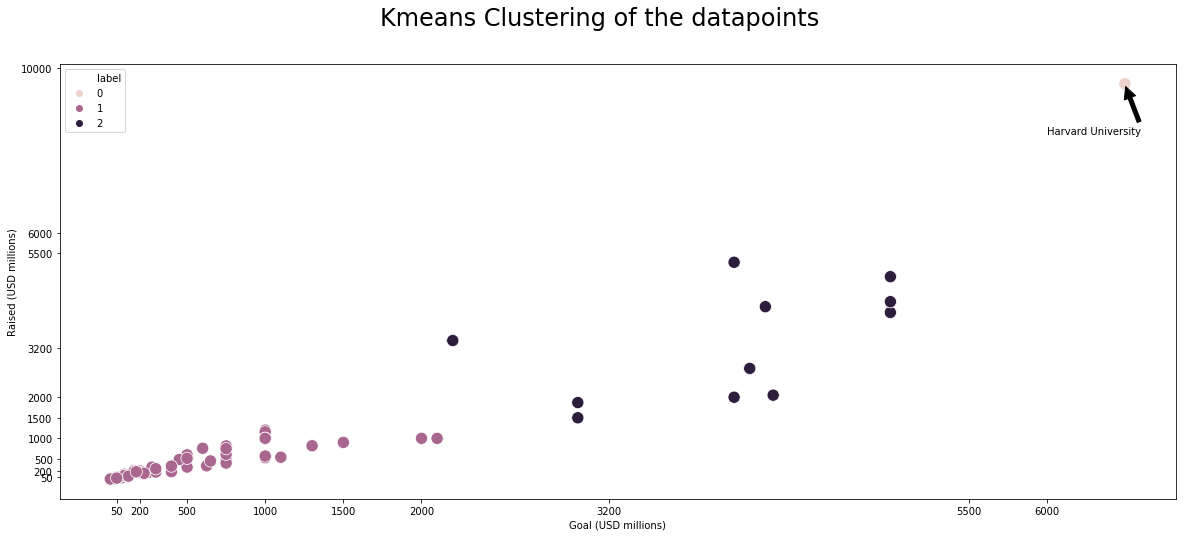

In [6]:
from sklearn.cluster import KMeans
from numpy.random import RandomState

kmeans = KMeans(n_clusters=3, random_state=RandomState(42)).fit(data)
data['label'] = pd.Series(kmeans.labels_, index=data.index)

plt.figure(figsize=(20,8))
plt.suptitle('Kmeans Clustering of the datapoints', fontsize=24)
plt.annotate('Harvard University', xy=(6500, 9600), xytext=(6000, 8400),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000])
plt.yticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000, 10000])
sns.scatterplot(x="Goal (USD millions)", y="Raised (USD millions)", s=150,hue='label' , data=data)

#### Insights based on Kmeans Clustering:
Kmeans divides sample of data into three clusters having raised against goal from low, medium, high.

1. Top most cluster 0, highest cluster showing maximum goal and raised more than planned which is only single observation or could be an outlier
2. Cluster 1, low cluster having small goal and fund raised
3. Custer 2, medium cluster having mid range goal and fund raised

Usually universities keep goal based on their expectations and mostly cluster 1 which is below USD 1000 millions whereas some universities keeping goal above USD 2000 which goes upto USD 6000 millions.


#### Step 5: Scatter plot visualizing line fit - predictive scatter

Fitting line to this data shows reasonable scatter aroung line with one observed exception. It can be checked further later in analysis.

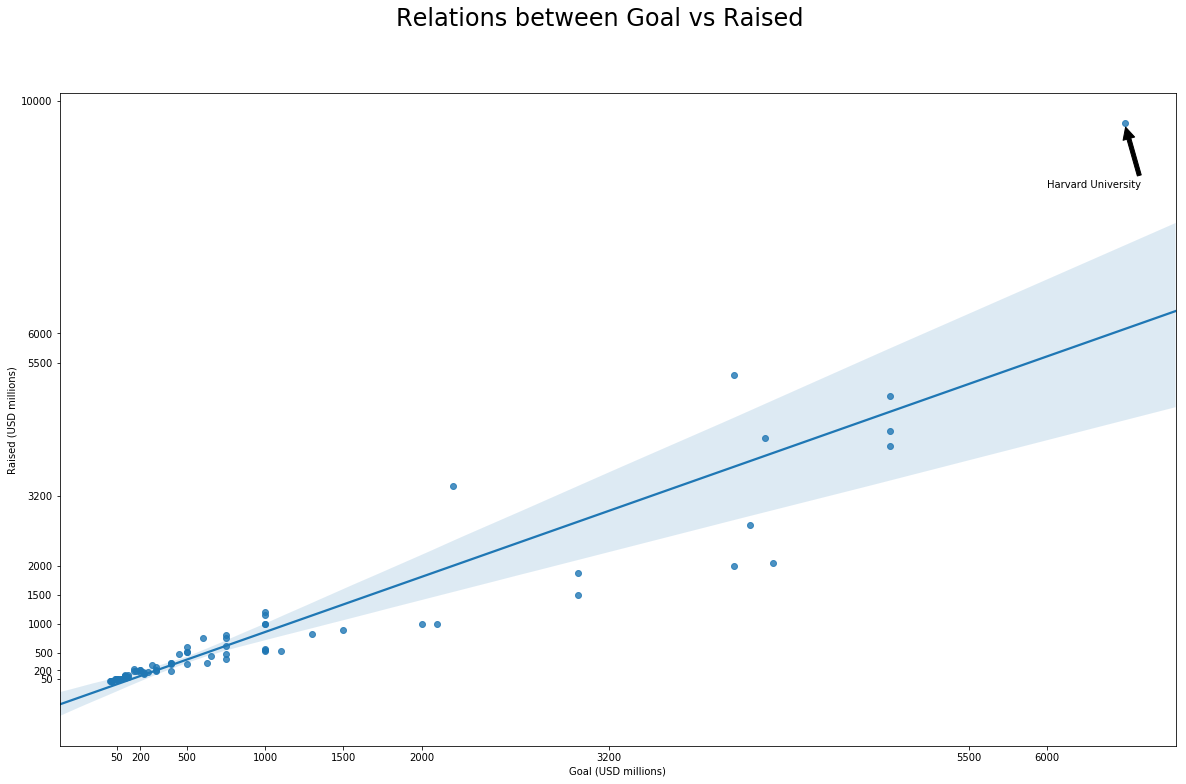

In [7]:
plt.figure(figsize=(20,12))
plt.suptitle('Relations between Goal vs Raised', fontsize=24)
plt.annotate('Harvard University', xy=(6500, 9600), xytext=(6000, 8500),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000])
plt.yticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000, 10000])
sns.regplot(x="Goal (USD millions)", y="Raised (USD millions)",data=data)

The outlier exception shown in data is for Harvard University raising tremendous amount of fund USD 9620.0 millions (approx 9.6 biilion) against planned goal USD 6500.0 millions topping it by USD 3120.0 millions in 5 years starting 2013 ending 2018 which can be validated from below university news article.

https://www.thecrimson.com/article/2018/4/15/capital-campaign-passes-9-billion/

Note: not penalising that row for now.

#### Step 6: Number of Universities can be divided into two groups:

1. Campaign already ended - 22 universities
2. Campaign not ended - 60

Since, data has many universities with campaign not ended. 

In [8]:
data['Ended'].value_counts()

False    60
True     22
Name: Ended, dtype: int64

#### Step 7: Performance Comparison of finished university campaings: 

At the end of the campaign, Most Universities have reported fund raised atleast what was planned. University of Michigan and Harvard University making most out of The Campaign.

<Figure size 2160x864 with 0 Axes>

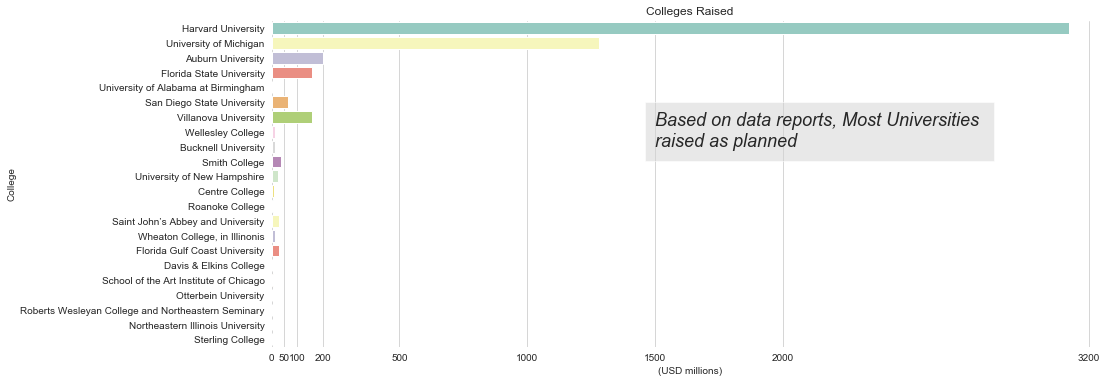

In [9]:
campEnded = uni.loc[uni['Ended'] == True].sort_values(by=['Raised (USD millions)'], ascending=False)

plt.figure(figsize=(30,12))
plt.suptitle('Top Performing Universities and Colleges(Campaign ended)', fontsize=24)


index = np.arange(22)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
ax = sns.barplot(campEnded['Raised Against Goal'], campEnded['College'], palette="Set3");
plt.text(1500, 8, 'Based on data reports, Most Universities \nraised as planned', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.xlabel('(USD millions)')
plt.title('Colleges Raised')
plt.xticks([0, 50, 100, 200, 500, 1000, 1500, 2000, 3200])
#ax.set_title('Histogram', size=20)
sns.despine(bottom=True, left=True);
plt.show();

#### Step 7: Top donation amount receiving university list

These are the universities receiving largest donations based on donors data. John Hokins tops with USD 1800 millions followed by Harvard-MIT and then columbia.

<Figure size 2160x864 with 0 Axes>

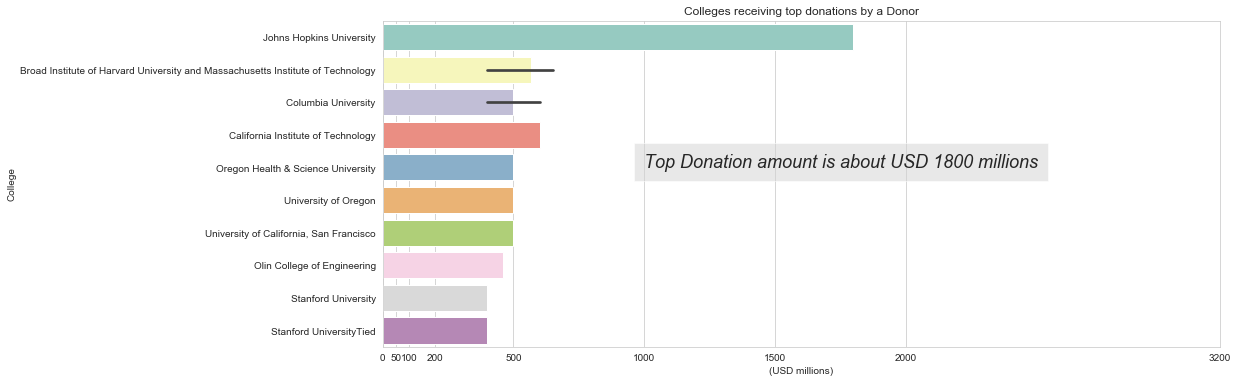

In [10]:
donortop = donor.sort_values(by=['Amount Given (USD millions)'], ascending=False).head(n=15)

plt.figure(figsize=(30,12))
#plt.suptitle('Top Performing Universities and Colleges(Campaign ended)', fontsize=24)


index = np.arange(22)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
sns.barplot(donortop['Amount Given (USD millions)'], donortop['College'], palette="Set3")
plt.text(1000, 4, 'Top Donation amount is about USD 1800 millions', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.xlabel('(USD millions)')
plt.title('Colleges receiving top donations by a Donor')
plt.xticks([0, 50, 100, 200, 500, 1000, 1500, 2000, 3200])
plt.show()

#### Step 8: Number of years of campaign duration among Universities

Most of the universities do campaign from 2.5 years to 6 years keeping their raising goal approximately aroung USD 3000 millions.

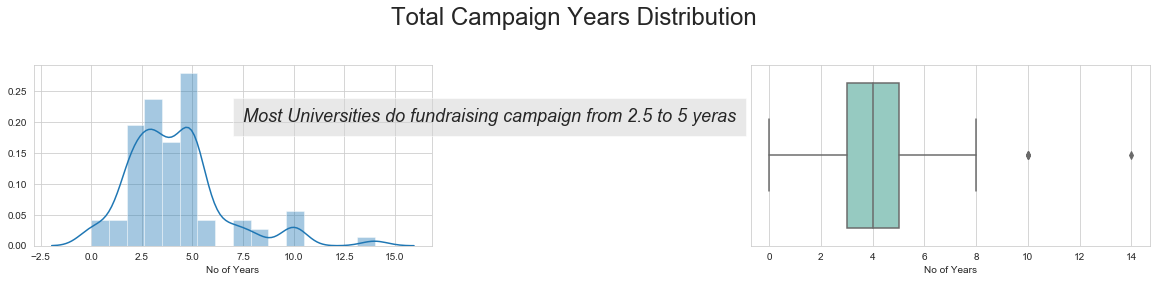

In [11]:
plt.figure(figsize=(20,8))
plt.suptitle('Total Campaign Years Distribution', fontsize=24)

plt.subplot(2,2,1)
sns.distplot(uni['No of Years'])
plt.text(7.5, 0.2, 'Most Universities do fundraising campaign from 2.5 to 5 yeras', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.subplot(2,2,2)
sns.boxplot(x=uni['No of Years'], palette="Set3")
plt.subplots_adjust(hspace=0.2, wspace = 0.2 )

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

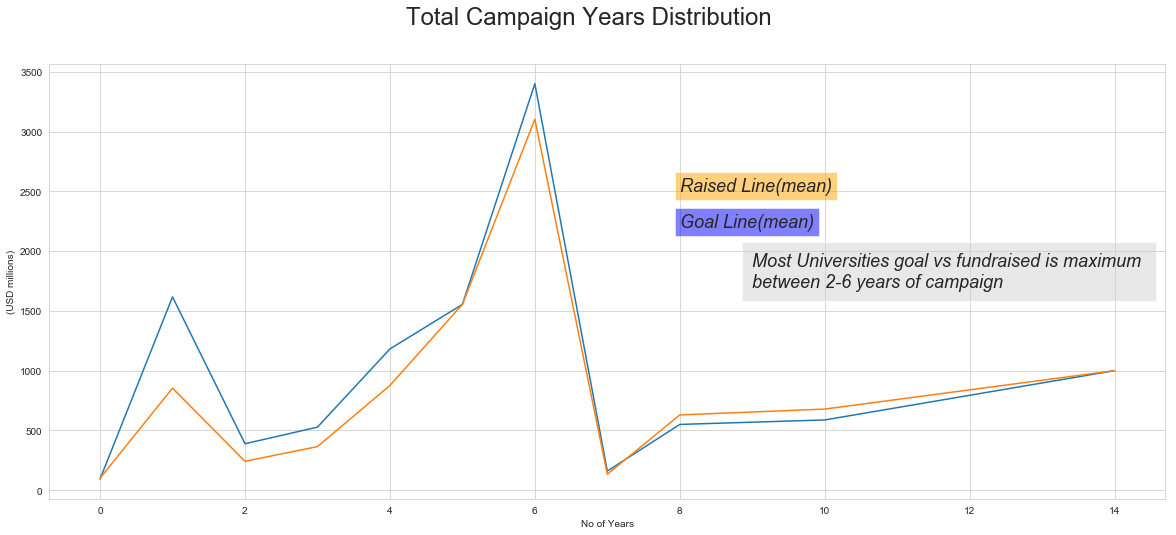

In [12]:
plt.figure(figsize=(20,8))
plt.suptitle('Total Campaign Years Distribution', fontsize=24)
plt.text(8, 2500, 'Raised Line(mean)', fontsize=18, style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 5})
plt.text(8, 2200, 'Goal Line(mean)', fontsize=18, style='italic', bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
plt.text(9, 1700, 'Most Universities goal vs fundraised is maximum \nbetween 2-6 years of campaign', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
newdf = uni.groupby(['No of Years'], as_index=False)['Goal (USD millions)'].mean()
sns.lineplot(x="No of Years", y="Goal (USD millions)", data=newdf)

newdf = uni.groupby(['No of Years'], as_index=False)['Raised (USD millions)'].mean()
sns.lineplot(x="No of Years", y="Raised (USD millions)", data=newdf)
plt.ylabel("(USD millions)")
plt.subplots_adjust(hspace=0.4, wspace = 0.8)

#### Step 9: Quick look at number of prospective donors around the states

Findings in below donors plots:
- Number of donors have been incresed since 2015 as there is peek in 2019 which 35 of them donating more than USD 50 millions.
- Increase is number can be easily seen with decrease in average amount of donation.

Please ignore year 2019, 2020 points as there is not data present to show.

Text(2000,1500,'Number of donors(Donating millions) increasing over years')

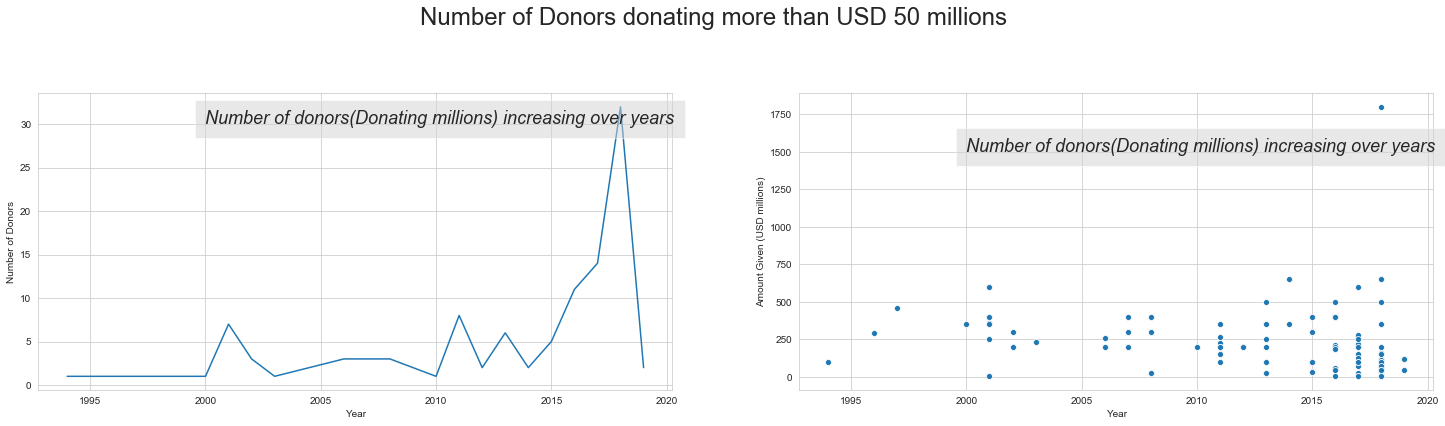

In [13]:
plt.figure(figsize=(25,12))
plt.suptitle('Number of Donors donating more than USD 50 millions', fontsize=24)

plt.subplot(2,2,1)
newdf = donor.groupby(['Year'], as_index=False).count()

sns.lineplot(x="Year", y="Amount Given (USD millions)", data=newdf)
plt.text(2000, 30, 'Number of donors(Donating millions) increasing over years', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.ylabel("Number of Donors")
plt.subplot(2,2,2)

sns.scatterplot(x="Year", y="Amount Given (USD millions)", data=donor)
plt.text(2000, 1500, 'Number of donors(Donating millions) increasing over years', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})

#### Step 10: Average number of top amount donors increased over time decreasing average donation around USD 200 million

Please note - we do exact records on top amount which is being donated to universities

Text(2013,400,'Average Donation Amount \nper donor(Donating millions)')

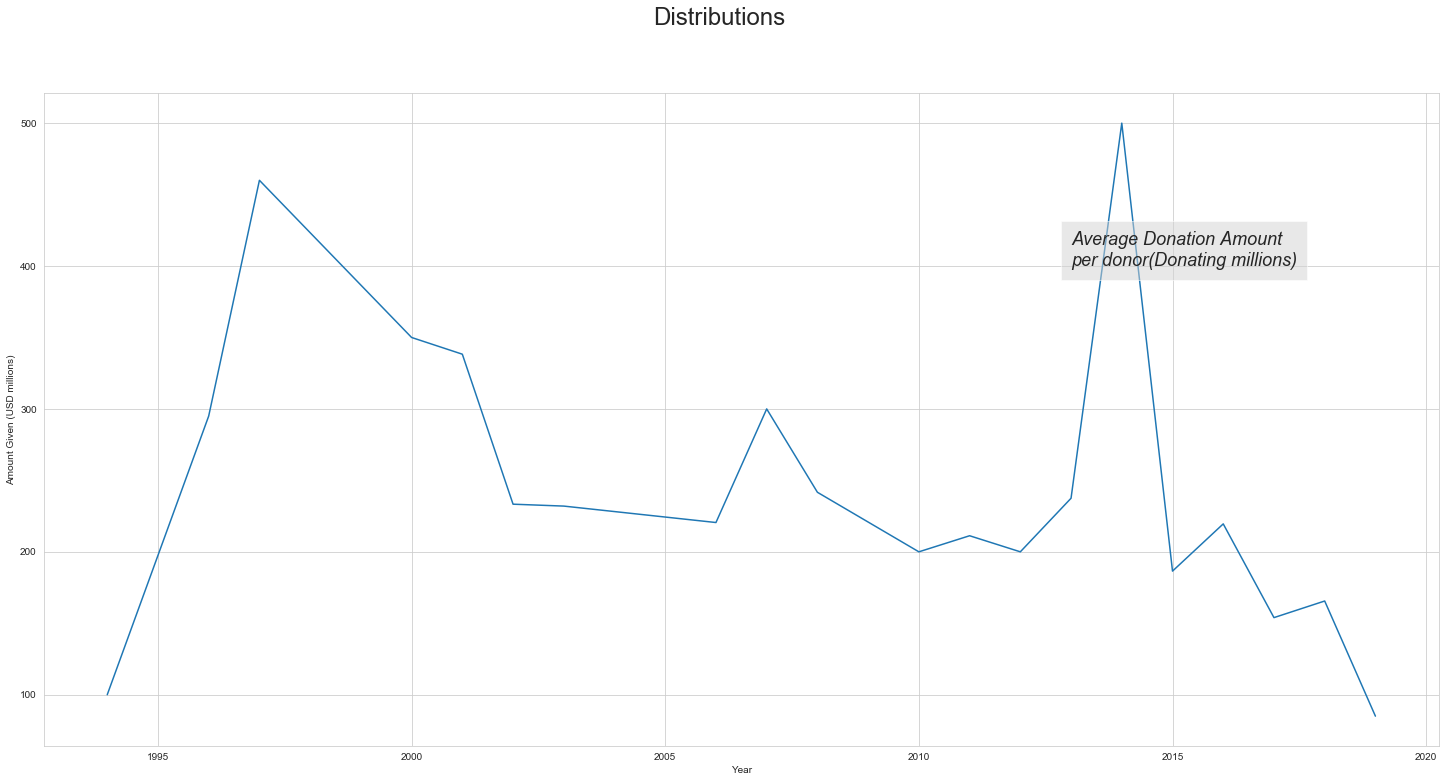

In [14]:
plt.figure(figsize=(25,12))
plt.suptitle('Distributions', fontsize=24)

newdf = donor.groupby(['Year'], as_index=False)['Amount Given (USD millions)'].mean()
sns.lineplot(x="Year", y="Amount Given (USD millions)", data=newdf)
plt.text(2013, 400, 'Average Donation Amount \nper donor(Donating millions)', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})

#### Step 11: Looking at Top and Bottom performing Universities so far 

These list can be used to compare and contrast university campaign strategies against the university performin good and bad during their campaigns.

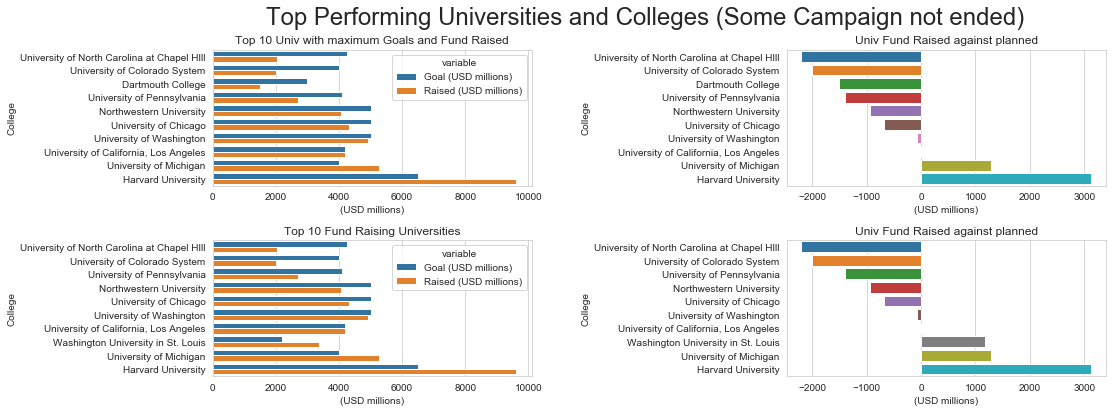

In [15]:
# Top 10 Universities exceeded goal including Campaign Not Ended
dftop = uni.sort_values(by=['Goal (USD millions)'], ascending=False).head(n=10)
index = np.arange(10)
bar_width = 0.25
opacity = 0.8

plt.figure(figsize=(16,6))
plt.suptitle('Top Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)


plt.subplot(2,2,1)
sns.set_style('whitegrid')
testtop = pd.melt(dftop, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testtop = testtop.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testtop)
plt.xlabel('(USD millions)')
plt.title('Top 10 Univ with maximum Goals and Fund Raised')

plt.subplot(2,2,2) 
sns.set_style('whitegrid')
sns.barplot(testtop['Raised Against Goal'], testtop['College'])
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

# Top 10 Universities max raised including Campaign not Ended
dftop2 = uni.sort_values(by=['Raised (USD millions)'], ascending=False).head(n=10)


plt.subplot(2,2,3) 
sns.set_style('whitegrid')
testtop2 = pd.melt(dftop2, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testtop2 = testtop2.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testtop2)
plt.xlabel('(USD millions)')
plt.title('Top 10 Fund Raising Universities')

plt.subplot(2,2,4) 
sns.set_style('whitegrid')    
sns.barplot(testtop2['Raised Against Goal'], testtop2['College'])

plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

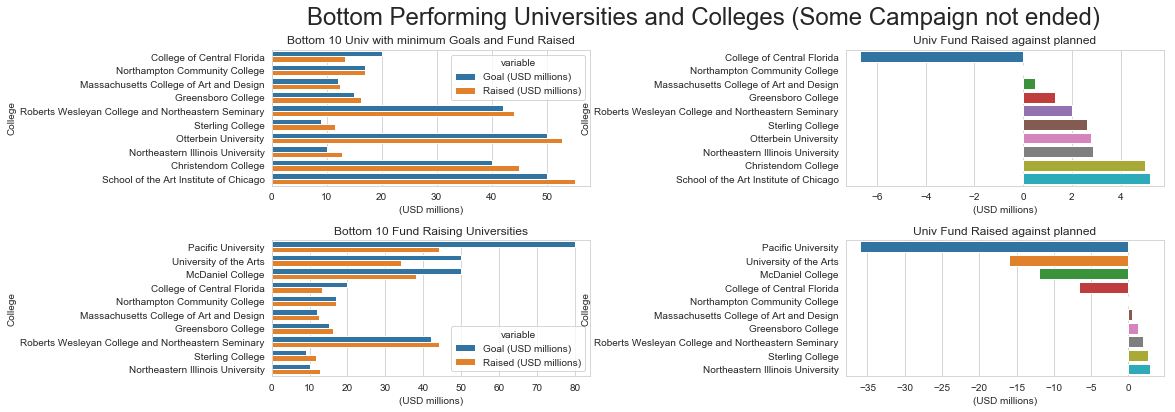

In [16]:
# Bottom 10 Universities including Campaign Not Ended
dfbottom = uni.sort_values(by=['Goal (USD millions)'], ascending=False).tail(n=10)
index = np.arange(10)
bar_width = 0.25
opacity = 0.8

plt.figure(figsize=(16,6))
plt.suptitle('Bottom Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)

plt.subplot(2,2,1)
sns.set_style('whitegrid')
testbtm = pd.melt(dfbottom, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testbtm = testbtm.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testbtm)
plt.xlabel('(USD millions)')
plt.title('Bottom 10 Univ with minimum Goals and Fund Raised')
plt.subplot(2,2,2) 
sns.set_style('whitegrid')
sns.barplot(testbtm['Raised Against Goal'], testbtm['College'])
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

# Top 10 Universities max raised including Campaign not Ended
dfbottom2 = uni.sort_values(by=['Raised (USD millions)'], ascending=False).tail(n=10)


plt.subplot(2,2,3) 
sns.set_style('whitegrid')
testbtm2 = pd.melt(dfbottom2, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testbtm2 = testbtm2.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testbtm2)
plt.xlabel('(USD millions)')
plt.title('Bottom 10 Fund Raising Universities')

plt.subplot(2,2,4) 
sns.set_style('whitegrid')    
sns.barplot(testbtm2['Raised Against Goal'], testbtm2['College'])

plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

In [17]:
#x = df.sort_values(by=['Raised (USD millions)'], ascending=False)
#x= x.drop([23])
#x.head()

#### Step 12: Natural Language Processing:

This notebook goes through a necessary step of any data science project - data cleaning. Data cleaning is a time consuming and unenjoyable task, yet it's a very important one. Keep in mind, "garbage in, garbage out". Feeding dirty data into a model will give us results that are meaningless.

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words
* Stemming / lemmatization

**More data cleaning steps after tokenization:**
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

Specifically, we'll be walking through:

1. **Cleaning the data -** we will walk through popular text pre-processing techniques
2. **Organizing the data -** we will organize the cleaned data into a way that is easy to input into other algorithms
3. **Bag words model**
4. **Word cloud comparison**

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from textblob import TextBlob
import string
import re

stop_words = set(stopwords.words('english')) 

def _clean(txt):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    txt = txt.lower()
    # punctuation removal 
    txt = ''.join(x for x in txt if x not in string.punctuation)
    txt = re.sub('\[.*?\]', ' ', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), ' ', txt)
    txt = re.sub('\w*\d\w*', ' ', txt)
    txt = re.sub('[‘’“”…]', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub(r"\ba\b","",txt)
    # stopwords removal  
    word_tokens = word_tokenize(txt)    
    clean_txt = [w for w in word_tokens if not w in stop_words]  
    clean_txt = ""
  
    for w in word_tokens:
        if w not in stop_words:
            clean_txt += " "
            clean_txt += w 
    
    clean_txt = ' '.join(clean_txt.split()) # Removing multiple whitespaces
    noise = ['students','my','title', 'would', 'every', 'will','and', 'for', 'many','also','donotremoveessaydivider']
    for ns in noise:
        clean_txt = clean_txt.replace(ns, "")

    return clean_txt

newdf = uni.sort_values(by=['Raised (USD millions)'], ascending=False).filter(['Top priorities'], axis=1)
newdf['Top priorities'] = newdf['Top priorities'].apply(_clean)
donortext['Primary Purpose'] = donortext['Primary Purpose'].apply(_clean)

**Zipf's Law:** Let f(w) be the frequency of a word w in free text. Suppose that all the words of a text are ranked according 
to their frequency, with the most frequent word first. Zipf's law states that the frequency of a word type is inversely proportional to its rank (i.e. f × r = k, for some constant k). For example, the 50th most common word type should occur three times as frequently as the 150th most common word type.

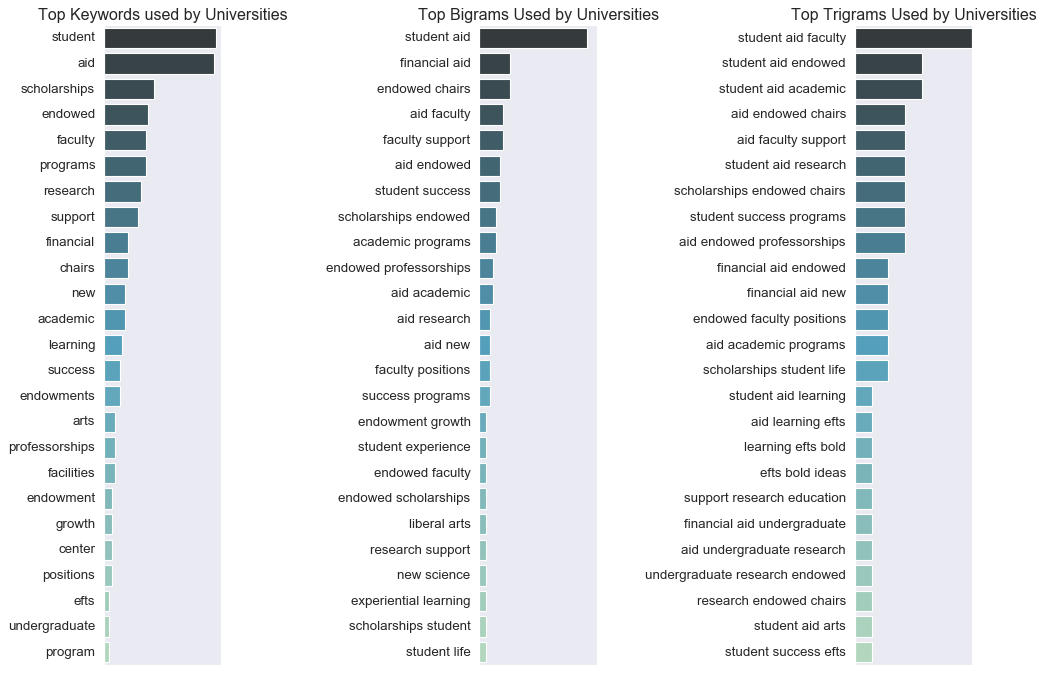

In [19]:
#s_copy = df.copy()
import pandas as pd
plt.style.use('classic')
### Bag of Words 
from collections import Counter
def generate_ngrams(txt, N):
    grams = [txt[i:i+N] for i in range(len(txt)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams 

newdf['unigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 1)))
newdf['bigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 2)))
newdf['trigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 3)))

all_unigrams = []
for each in newdf['unigrams']:
    all_unigrams.extend(each)
t = Counter(all_unigrams).most_common(25)
x = [a[0] for a in t]
y = [a[1] for a in t]

all_bigrams = []
for each in newdf['bigrams']:
    all_bigrams.extend(each)
t1 = Counter(all_bigrams).most_common(25)
x1 = [a[0] for a in t1]
y1 = [a[1] for a in t1]


all_trigrams = []
for each in newdf['trigrams']:
    all_trigrams.extend(each)
t2 = Counter(all_trigrams).most_common(25)
x2 = [a[0] for a in t2]
y2 = [a[1] for a in t2]

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=True, figsize = (14,10));

bar = sns.barplot(y=x, x=y, ax=axes[0], palette='GnBu_d', edgecolor="white");
bar.set(xlabel='', xticks=[]);
axes[0].set_title("Top Keywords used by Universities");

fig.delaxes(axes[1]);

bar1 = sns.barplot(y=x1, x=y1, ax=axes[2], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[2].set_title("Top Bigrams Used by Universities");

fig.delaxes(axes[3]);

bar1 = sns.barplot(y=x2, x=y2, ax=axes[4], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[4].set_title("Top Trigrams Used by Universities");

plt.subplots_adjust(hspace=0.2, wspace = 0.6)

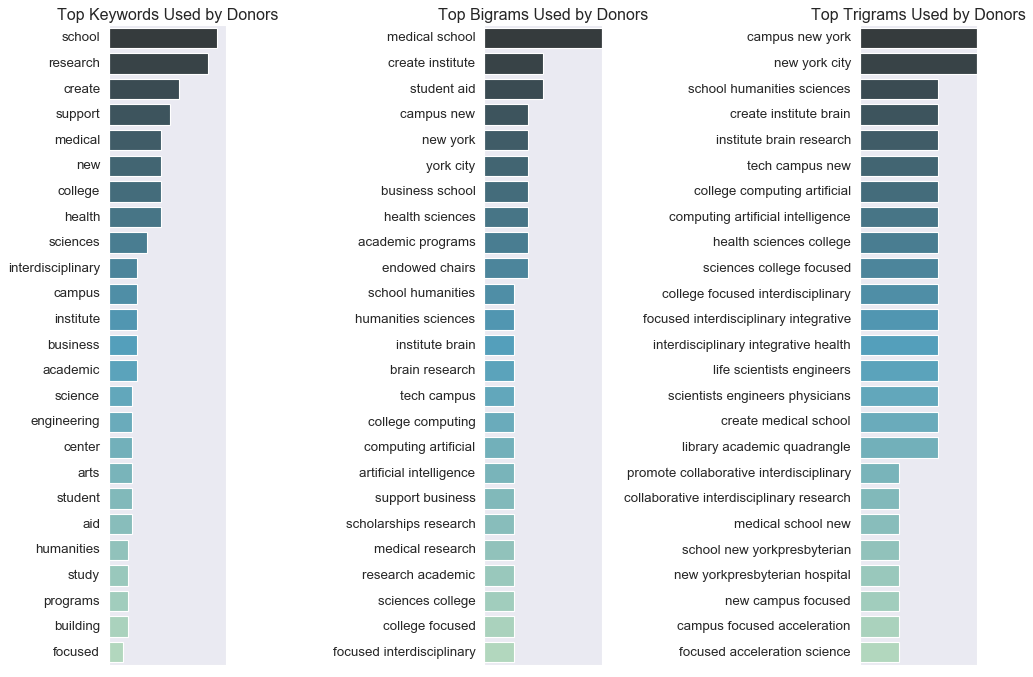

In [20]:
#s_copy = df.copy()
import pandas as pd
plt.style.use('classic')
### Bag of Words 
from collections import Counter
def generate_ngrams(txt, N):
    grams = [txt[i:i+N] for i in range(len(txt)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams 

donortext['unigrams'] = pd.DataFrame(donortext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 1)))
donortext['bigrams'] = pd.DataFrame(donortext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 2)))
donortext['trigrams'] = pd.DataFrame(donortext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 3)))

all_unigrams = []
for each in donortext['unigrams']:
    all_unigrams.extend(each)
t = Counter(all_unigrams).most_common(25)
x = [a[0] for a in t]
y = [a[1] for a in t]

all_bigrams = []
for each in donortext['bigrams']:
    all_bigrams.extend(each)
t1 = Counter(all_bigrams).most_common(25)
x1 = [a[0] for a in t1]
y1 = [a[1] for a in t1]


all_trigrams = []
for each in donortext['trigrams']:
    all_trigrams.extend(each)
t2 = Counter(all_trigrams).most_common(25)
x2 = [a[0] for a in t2]
y2 = [a[1] for a in t2]

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=True, figsize = (14,10));

bar = sns.barplot(y=x, x=y, ax=axes[0], palette='GnBu_d', edgecolor="white");
bar.set(xlabel='', xticks=[]);
axes[0].set_title("Top Keywords Used by Donors");

fig.delaxes(axes[1]);

bar1 = sns.barplot(y=x1, x=y1, ax=axes[2], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[2].set_title("Top Bigrams Used by Donors");

fig.delaxes(axes[3]);

bar1 = sns.barplot(y=x2, x=y2, ax=axes[4], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[4].set_title("Top Trigrams Used by Donors");

plt.subplots_adjust(hspace=0.2, wspace = 0.6)

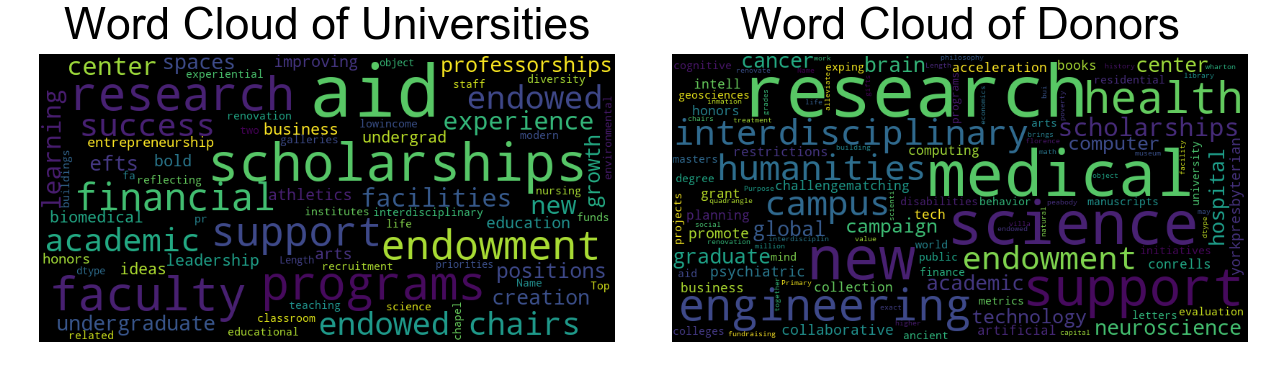

In [21]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'school', 'student', 'students', 'college', 'program', 'create', 'institute', 'study', 'matching', 'york',
                      'creating', 'city', 'department', 'rare', 'focused', 'miami'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    #plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    

plt.figure(figsize=(16,10))
#plt.suptitle('Bottom Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)

plt.subplot(2,2,1)
plot_wordcloud(newdf["Top priorities"], title="Word Cloud of Universities")

plt.subplot(2,2,2)
plot_wordcloud(donortext["Primary Purpose"], title="Word Cloud of Donors")

### Insights from Natural language Processing shows:

- Universities are more on prioritizing scholarships, aid, facilities and faculty 
- Donors give moe preference towards medical, reserach, humanities, science and health

### CONCLUSION: 

#### With that being analyzed, Top Performing Universities listed on the highered website can be used as inspiration building fundraising campaign whereas the ones performing badly to ignore bad strategies.

- Prioritizing research and health in Educational Projects could help grow institution as well as building pool of prospects for the universities strategic initiatives.
- Keep a separate website portal where academic project requirements and donors point of view can be published (Ultimately posting what college need to grow research + achievements and popularizing donors point of view on higher education board).
- Get inspiration from Harvard Universities campaigning strategies (https://www.philanthropy.com/article/How-Harvard-Raised-96/244716).
- Over the years, the total number of donors donating USD in millions is increasing (Varies based on tax benefits, stocks, personal point of view on funding Education).
- Universities organizing 3-5 years of a campaign with appropriate raising goal based on current and/or the future market has a good chance of raising funding for the institution.

**Key Notes:**

- Whatever Data available is inaccurate with many msissing values.
- It could be inferred to change overall fundraising workflow prioritizing Social expectations.

#### MIscellineous

In [22]:
import scattertext as st
import spacy
from pprint import pprint

In [23]:
convention_df = st.SampleCorpora.ConventionData2012.get_data() 
convention_df['party'].unique()

array(['democrat', 'republican'], dtype=object)

In [24]:
newdf["type"] = "Universities"
donortext["type"] = "Donors"

In [25]:
newdf = newdf.drop(['unigrams', 'bigrams', 'trigrams'], axis=1)

In [26]:
donortext = donortext.drop(['unigrams', 'bigrams', 'trigrams'], axis=1)

In [27]:
donortext['Top priorities'] = (donortext['Primary Purpose'])
newdf = newdf.append(donortext)
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 23 to 77
Data columns (total 3 columns):
Primary Purpose    106 non-null object
Top priorities     188 non-null object
type               188 non-null object
dtypes: object(3)
memory usage: 5.9+ KB


In [29]:
nlp = spacy.load('en_core_web_sm')
corpus = st.CorpusFromPandas(newdf, 
                              category_col='type', 
                              text_col='Top priorities',
                              nlp=nlp).build()

In [35]:
html = st.produce_scattertext_explorer(corpus,
          category='Donors',
          category_name='Donors',
          not_category_name='Universities',
          width_in_pixels=1000)

In [36]:
open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))


330914

In [37]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['needblind', 'lowincome', 'exping', 'facultyled', 'crossdisciplinary', 'conrells', 'inmation', 'matchingchallenge', 'afdability', 'yorkpresbyterian']
